# Боқтық Сөйлеуді Анықтау

In [28]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [31]:
dataset = pd.read_csv("hate_speech_kazakh.csv")
dataset

,tweet,label
0,«» «@ Blackman38Tide: @WhaleLookyHere @ HowdyD...,боқтық мәнді
1,«» «@ CB_Baby24: @white_thunduh alsarabsss» «е...,боқтық мәнді
2,"«» «@DevilGrimz: @VigxRArts сен гомосексуалды,...",боқтық мәнді
3,«» «@MarkRoundtreeJr: LMFAOOOO Мен қара адамда...,боқтық мәнді
4,"«» «@NoChillPaz:» «Мен, ең болмағанда, ниггер ...",боқтық мәнді
...,...,...
26397,яя хо .. сүйкімді avi tho RT @ViVaLa_Ari мен о...,нейтраль мәнді
26398,"иә, сондықтан @N_tel-дің жаңа досы туралы .. м...",нейтраль мәнді
26399,"«сен олардың не айтатынын білесің, ерте құс құ...",нейтраль мәнді
26400,"«сен кетіп, дұрыс емес жүректі баламды сындыры...",нейтраль мәнді


In [32]:
dataset['text length'] = dataset['tweet'].apply(len)
print(dataset.head())

                                               tweet         label  \
0  «» «@ Blackman38Tide: @WhaleLookyHere @ HowdyD...  боқтық мәнді   
1  «» «@ CB_Baby24: @white_thunduh alsarabsss» «е...  боқтық мәнді   
2  «» «@DevilGrimz: @VigxRArts сен гомосексуалды,...  боқтық мәнді   
3  «» «@MarkRoundtreeJr: LMFAOOOO Мен қара адамда...  боқтық мәнді   
4  «» «@NoChillPaz:» «Мен, ең болмағанда, ниггер ...  боқтық мәнді   

   text length  
0           62  
1          114  
2          136  
3          132  
4           81  


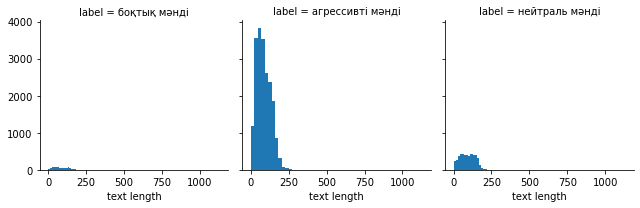

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=dataset, col='label')
graph.map(plt.hist, 'text length', bins=50)

- а. мәтін ұзындығының таралуы барлық үш сыныпта бірдей
- ә. твиттер саны агрессивты-сыныпқа қарағанда едәуір көп болып көрінеді


Text(0.5, 1.0, 'Бокс плот арқылы графикада көрсету')

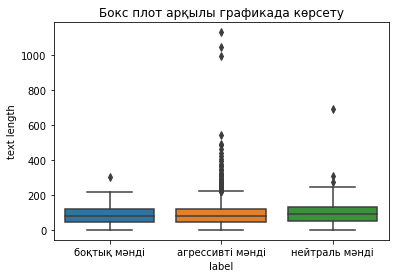

In [36]:
sns.boxplot(x='label', y='text length', data=dataset)
plt.title('Бокс плот арқылы графикада көрсету')

From the box-plot, looks like the class-1 tweets have much longer text. There are also outliers present so text-length won’t be a useful feature to consider.

Text(0.5, 1.0, 'Гистограмма арқылы графикада көрсету')

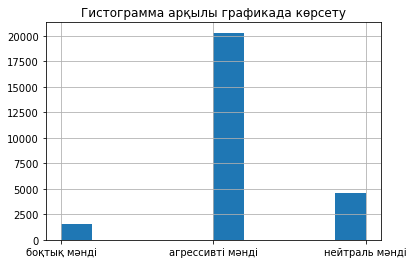

In [38]:
dataset['label'].hist()
plt.title('Гистограмма арқылы графикада көрсету')

Жоғарыда келтірілген гистограмма Твиттердің көпшілігі CF кодерлерінің қорлайтын сөздері болып саналатынын көрсетеді.

In [39]:
# тек CSV файлынан твиттерді айнымалы аты бар Твиттерге жинау
tweet=dataset.tweet

## Твиттерді алдын-ала өңдеу

In [61]:
stopwords = nltk.corpus.stopwords.words("kazakh")

def preprocess(tweet):  
    
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    punc_remove = tweets.str.replace("[^А-Я,а-я,Ә,І,Ң,Ғ,Ү,Ұ,Қ,Ө,Һ,ә,і,ə,ң,ғ,ү,ұ,қ,ө,һ]", " ")

    newtweet=punc_remove.str.replace(r'\s+', ' ')

    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')

    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')

    tweet_lower = newtweet.str.lower()
    

    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
 
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)

dataset['processed_tweets'] = processed_tweets
dataset = dataset[dataset.processed_tweets.apply(lambda x: True if len(x.split(' ')) > 3 else False)]
dataset['class'] = dataset['label'].apply(lambda x: 0 if x == 'агрессивті мәнді' else 1 if x == 'боқтық мәнді' else 2)
print(dataset[["tweet","processed_tweets"]].head(10))

                                                tweet  \
1   «» «@ CB_Baby24: @white_thunduh alsarabsss» «е...   
2   «» «@DevilGrimz: @VigxRArts сен гомосексуалды,...   
3   «» «@MarkRoundtreeJr: LMFAOOOO Мен қара адамда...   
4   «» «@NoChillPaz:» «Мен, ең болмағанда, ниггер ...   
6   «» «@ NotoriousBM95: @_WhitePonyJr_ Ариза - жы...   
7   «» «@RTNBA: Nike / Jordan шығаратын жаңа аяқ к...   
8   «» «@TheoMaxximus: #GerrysHalloweenParty http:...   
9   «» «@ashlingwilde: @ItsNotAdam сүйкімді болуы ...   
10  «» «@bigbootybishopp: @white_thunduh lassen cc...   
11  «» «@jayswaggkillah: Джеки баяу # аққұба пробл...   

                                     processed_tweets  
1   егер мексикалық деп айта алсаңыз, бұршақпен ай...  
2   гомосексуалды, қара тізімге ілінетін құрт бәрі...  
3   қара адамдарды жек көремін қара нәсілділер ниг...  
4                  мен, ең болмағанда, ниггер емеспін  
6   ариза жылан және қорқақ ол, ең болмаса, кейіпк...  
7   шығаратын жаңа аяқ киімдерді дра

c:\users\yelzha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Визуализациялау

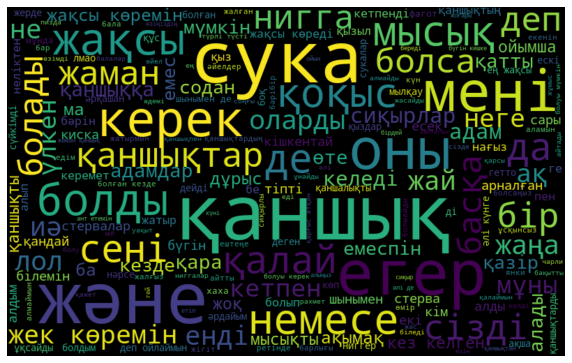

In [62]:
# Twitter деректер жиынтығында қай сөз жиі қолданылатынын визуализациялау
from wordcloud import WordCloud
all_words = ' '.join([text for text in dataset['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

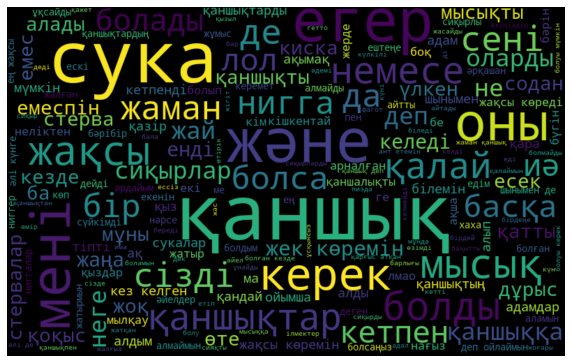

In [64]:
# жек көруді білдіру үшін қай сөз жиі қолданылатынын визуализациялау
hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

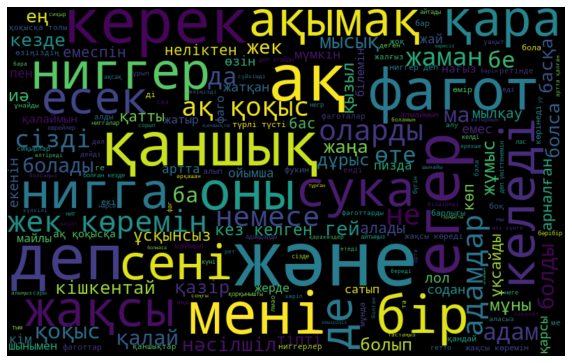

In [65]:
# қорлайтын сөйлеу үшін қай сөз жиі қолданылатынын визуализациялау
offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Техникалық Сипаттама

In [122]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.2, min_df=0.001)
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
tfidf

<20447x1148 sparse matrix of type '<class 'numpy.float64'>'
	with 97684 stored elements in Compressed Sparse Row format>

### Қосымша мүмкіндіктерсіз TFIDF көмегімен әртүрлі модельдерді іске қосу

In [123]:
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Логистикалық регрессия, дәлдікті бағалау:" , acc)


              precision    recall  f1-score   support

           0       0.83      0.97      0.90      3151
           1       0.42      0.04      0.07       204
           2       0.74      0.42      0.54       735

   micro avg       0.82      0.82      0.82      4090
   macro avg       0.66      0.48      0.50      4090
weighted avg       0.80      0.82      0.79      4090

Логистикалық регрессия, дәлдікті бағалау: 0.8227383863080685


In [124]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Кездейсоқ Орман, Дәлдікті Бағалау:",acc1)

              precision    recall  f1-score   support

           0       0.84      0.93      0.89      3151
           1       0.29      0.10      0.15       204
           2       0.64      0.46      0.54       735

   micro avg       0.81      0.81      0.81      4090
   macro avg       0.59      0.50      0.52      4090
weighted avg       0.78      0.81      0.79      4090

Кездейсоқ Орман, Дәлдікті Бағалау: 0.8075794621026895


In [125]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Наивты Байес, Дәлдікті Бағалау:",acc2)

              precision    recall  f1-score   support

           0       0.92      0.18      0.31      3151
           1       0.06      0.76      0.11       204
           2       0.41      0.43      0.42       735

   micro avg       0.26      0.26      0.26      4090
   macro avg       0.46      0.46      0.28      4090
weighted avg       0.78      0.26      0.32      4090

Наивты Байес, Дәлдікті Бағалау: 0.2569682151589242


In [126]:
support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, дәлдікті бағалау:" , acc3)

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      3151
           1       0.34      0.05      0.09       204
           2       0.67      0.50      0.57       735

   micro avg       0.82      0.82      0.82      4090
   macro avg       0.62      0.50      0.52      4090
weighted avg       0.79      0.82      0.80      4090

SVM, дәлдікті бағалау: 0.8207823960880195


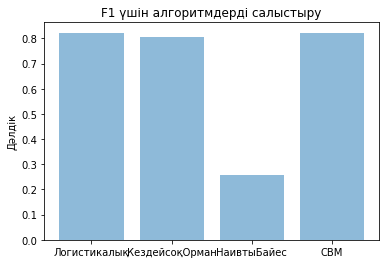

In [127]:
objects = ('Логистикалық', 'КездейсоқОрман', 'НаивтыБайес', 'СВМ')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Дәлдік')
plt.title('F1 үшін алгоритмдерді салыстыру')
plt.show()

In [128]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_tweets"].apply(lambda x: x.split(" ")))]

model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

doc2vec_df = dataset["processed_tweets"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
1,0.152094,-0.131167,0.035459,0.122054,0.098462
2,0.148002,-0.044905,0.017361,0.041464,-0.021074
3,0.057652,0.040046,-0.062578,-0.018812,0.074146
4,0.145069,-0.000869,0.055783,0.011885,-0.019081
6,0.327789,-0.230828,-0.143132,0.054234,0.019528
...,...,...,...,...,...
26397,0.115078,-0.033071,0.048672,-0.025766,0.035761
26398,0.146628,-0.091769,-0.038885,-0.011262,-0.042530
26399,0.231117,-0.084206,0.019863,0.090777,0.035402
26400,0.117398,-0.097520,-0.129248,0.031184,-0.047171


In [129]:
modelling_features = np.concatenate([tfidf.toarray(),doc2vec_df],axis=1)
modelling_features.shape

(20447, 1153)

### doc2vec функциялары бар TFIDF көмегімен модельдерді іске қосу

In [130]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      3151
           1       0.50      0.04      0.08       204
           2       0.72      0.43      0.54       735

   micro avg       0.82      0.82      0.82      4090
   macro avg       0.68      0.48      0.51      4090
weighted avg       0.80      0.82      0.79      4090

Logistic Regression, Accuracy Score: 0.8227383863080685


In [131]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_preds = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3151
           1       0.37      0.05      0.09       204
           2       0.67      0.45      0.54       735

   micro avg       0.81      0.81      0.81      4090
   macro avg       0.63      0.48      0.51      4090
weighted avg       0.78      0.81      0.79      4090

Random Forest, Accuracy Score: 0.8144254278728607


In [133]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train,y_train)
y_preds = nb.predict(X_test)
acc2=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("Naive Bayes, Accuracy Score:",acc2)

              precision    recall  f1-score   support

           0       0.92      0.18      0.31      3151
           1       0.06      0.76      0.11       204
           2       0.41      0.43      0.42       735

   micro avg       0.26      0.26      0.26      4090
   macro avg       0.46      0.46      0.28      4090
weighted avg       0.78      0.26      0.32      4090

Naive Bayes, Accuracy Score: 0.2569682151589242


In [135]:
X = pd.DataFrame(modelling_features)
y = dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_preds = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_preds)
report = classification_report( y_test, y_preds )
print(report)
print("SVM, Accuracy Score:" , acc3)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      3151
           1       0.36      0.06      0.11       204
           2       0.68      0.50      0.58       735

   micro avg       0.82      0.82      0.82      4090
   macro avg       0.63      0.50      0.53      4090
weighted avg       0.80      0.82      0.80      4090

SVM, Accuracy Score: 0.823960880195599


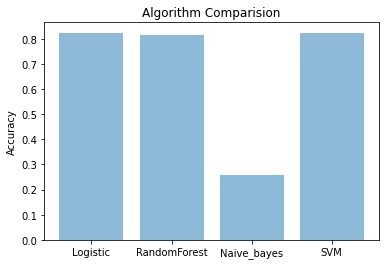

In [136]:
objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision')
plt.show()

In [150]:
from textstat.textstat import *
def additional_features(tweet): 
    
    syllables = textstat.syllable_count(tweet)
    num_chars = sum(len(w) for w in tweet)
    num_chars_total = len(tweet)
    num_words = len(tweet.split())

    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(tweet.split()))
    

    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    add_features=[FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(tweets):
    features=[]
    for t in tweets:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(dataset.processed_tweets)

In [151]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,doc2vec_df,fFeatures],axis=1)
modelling_features_enhanced.shape

(20447, 1161)

### doc2vec және жетілдірілген мүмкіндіктері бар tfidf көмегімен модельдерді іске қосу

In [153]:
X = pd.DataFrame(modelling_features_enhanced)
y = dataset['class'].astype(int)
X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

model = LogisticRegression().fit(X_train_features,y_train)
y_preds = model.predict(X_test_features)
report = classification_report( y_test, y_preds )
print(report)
acc=accuracy_score(y_test,y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      3133
           1       0.26      0.02      0.04       222
           2       0.77      0.43      0.56       735

   micro avg       0.82      0.82      0.82      4090
   macro avg       0.62      0.48      0.50      4090
weighted avg       0.79      0.82      0.79      4090

Logistic Regression, Accuracy Score: 0.8237163814180929


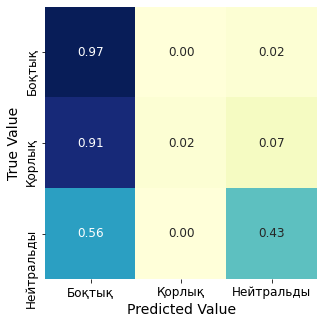

In [161]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Боқтық','Қорлық','Нейтральды']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)

Text(0, 0.5, 'Count')

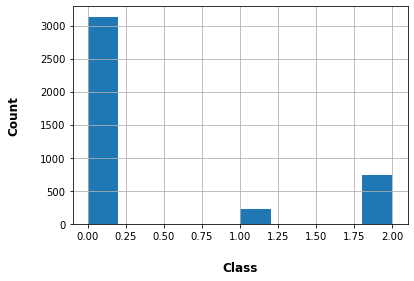

In [162]:
ax=y_test.hist()
ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)